# Math Model

The following diagram illustrates a $3 \times 3$ beam superposition process. Note that the center input beam is missing due to diffraction optical element configuration (zero order output suppressed).

![fig](fig/3d_plot.png)

For Fraunhofer diffraction,  matrix $d$ is the 2D fourier transform of grating, whose first $3\times 3$ elements are measured as:

$$
d = \begin{pmatrix}
        e^{j\theta_{00}} & e^{j\theta_{01}} & e^{j\theta_{02}} \\
        e^{j\theta_{10}} & 0\cdot e^{j\theta_{11}} & e^{j\theta_{12}} \\
        e^{j\theta_{20}} & e^{j\theta_{21}} & e^{j\theta_{22}}
    \end{pmatrix}
$$


Define input beam complex matrix $B$ with unknown phases $\delta_{xy}$:

$$
b = \begin{pmatrix}
        A_{00} e^{j\delta_{00}} & A_{01} e^{j\delta_{01}} & A_{02} e^{j\delta_{02}} \\
        A_{10} e^{j\delta_{10}} & A_{11} e^{j\delta_{11}} & A_{12} e^{j\delta_{12}} \\
        A_{20} e^{j\delta_{20}} & A_{21} e^{j\delta_{21}} & A_{22} e^{j\delta_{22}}
    \end{pmatrix}
$$

where $x,y$ is location index.

The diffraciton and beam superposition generates an output complex matrix $s$ which can be described as summation of each sub projection planes indexed by shifting locations $m,n$:

$$
    s(x,y) = \sum_{m=-\infty}^\infty \sum_{n=-\infty}^\infty b(x,y)d(x-m, y-n)
$$

In signal processing, this is the definition of 2D convolution. With a known $s(x,y)$, it is easy to use inverse 2D FFT to solve unknown beam information according to [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) in spatial frequency domain $u,v$.

\begin{align*}
    s(x,y) &= b(x,y) \ast d(x,y) \\
    & \Updownarrow \\
    S(u, v) &= B(u, v) D(u, v) \\
    B(u, v) &= \frac{S(u,v)}{D(u,v)} \\
    b(x,y) &= \mathcal{F}^{-1}\left( \frac{S(u,v)}{D(u,v)} \right)
\end{align*}

where $B(u,v)$ and $D(u,v)$ are 2D FFT of $b(x,y)$ and $d(x,y)$ respectively.

## Statement of problem

It is a common problem to many applications such as X-ray crystallography, electron microscope, image processing, etc., where only the magnitude of diffraction pattern $\lvert s(i,j) \rvert$ is measurable, and one has to retrieve its phase in order to do the inverse FFT. This is a non-linear process called phase retrival, which is very active research field in Coherernt Diffraction Imaging (CDI).

Using some constraints (known) on the input side, such as spatial non-zero locations (support) and positive real values, an iterative algorithm such as hybrid input-output (HIO) and its improvements are widely used. [1]

[1]: https://arxiv.org/pdf/1402.7350.pdf

   Note that the number of non-zero elements (first order):
   
   $$
   \begin{pmatrix}
       1 & 2 & 3 & 2 & 1 \\
       2 & 4 & 6 & 4 & 2 \\
       3 & 6 & 9 & 6 & 3 \\
       2 & 4 & 6 & 4 & 2 \\
       1 & 2 & 3 & 2 & 1       
   \end{pmatrix}
   $$

---
# Numerical simulation

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from combine_model import sim8, doe_phs_deg

%precision 2
np.set_printoptions(suppress=True)

def plot8(intensity, title=''):
    fig, ax = plt.subplots()
    c = ax.matshow(intensity, vmin=0, vmax=64, cmap=plt.get_cmap('gist_stern'))
    ax.set_title(title)
    fig.colorbar(c, ax=ax)
    return fig

print("Measured DOE phase [deg]:")
print(doe_phs_deg)

Measured DOE phase [deg]:
[[  0  90   0]
 [  0   0 -90]
 [180   0   0]]


## Random condition

In [5]:
beam_phs_deg = np.random.randn(*doe_phs_deg.shape) * 360

In [7]:
beam_phs_deg

array([[ 320.26, -327.62, -282.45],
       [ 302.01, -151.82,  553.55],
       [-222.6 ,  381.73, -144.58]])

[[1.   3.97 1.3  3.3  1.  ]
 [2.29 2.65 0.76 1.35 0.14]
 [4.89 4.31 0.79 1.5  7.89]
 [0.07 3.12 0.13 3.9  0.25]
 [1.   0.48 7.88 0.63 1.  ]]


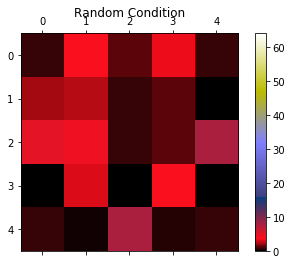

In [4]:
beam_phs_deg = np.random.randn(*doe_phs_deg.shape) * 360

intensity = sim8(beam_phs_deg)

print(intensity)
plot8(intensity, 'Random Condition');

## Ideal combining condition

It is simulated that when input beam phase is the 180 degree rotation and oppsosite of diffraction phase, the max coherent combining efficiency can be achieved.

[[ 1.  2.  1.  2.  1.]
 [ 2.  0.  0.  0.  2.]
 [ 1.  0. 64.  0.  1.]
 [ 2.  0.  0.  0.  2.]
 [ 1.  2.  1.  2.  1.]]


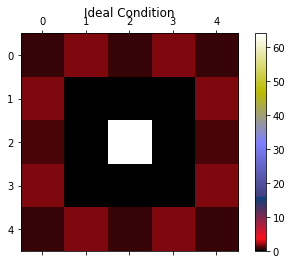

In [12]:
beam_phs_deg = np.rot90(np.rot90(-doe_phs_deg))

intensity = sim8(beam_phs_deg)

print(intensity)
plot8(intensity, 'Ideal Condition');

## Interactive plot

In [14]:
import ipywidgets as widgets

init_beam_phs_deg = beam_phs_deg.ravel()
xs = [widgets.IntSlider(
        description=str(divmod(ix,3)), min=-180, max=180, step=15, value=init_beam_phs_deg[ix]
        ) for ix in range(9)]

ui = widgets.VBox(xs)
phs_dict = {
    'x0': xs[0], 'x1': xs[1], 'x2': xs[2], 
    'x3': xs[3], 'x4': xs[4], 'x5': xs[5], 
    'x6': xs[6], 'x7': xs[7], 'x8': xs[8]
}

def draw_intensity(x0, x1, x2, x3, x4, x5, x6, x7, x8):
    beam_phs_deg = np.array([x0, x1, x2, x3, x4, x5, x6, x7, x8]).reshape(3,3)
    intensity = sim8(beam_phs_deg)
    plt.matshow(intensity, cmap=plt.get_cmap('gist_stern'), vmin=0, vmax=64)
    plt.show()
    print('center beam: {:.1f}'.format(intensity[2,2]))

img = widgets.interactive_output(draw_intensity, phs_dict)
widgets.HBox([ui, img]);